In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util
import random
from vtr.prior import formant
from lib import timit
from inv import process
from inv import model
from vtr.prior import filter

2023-02-24 13:48:53.897586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-24 13:48:53.897637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-24 13:48:53.897641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [11]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

In [3]:
# golden example
import pathlib
fb_file, phn_file, wav_file = (
 pathlib.PosixPath('/home/marnix/thesis/py/../data/VTRFormants/TEST/DR3/MLNT0/SI1902.FB'),
 pathlib.PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR3/MLNT0/SI1902.PHN'),
 pathlib.PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR3/MLNT0/SI1902.WAV')
)

NP = 14
Number of data points: 1250
Number of model dimensions: 282


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 PoleZeroFilter(4))

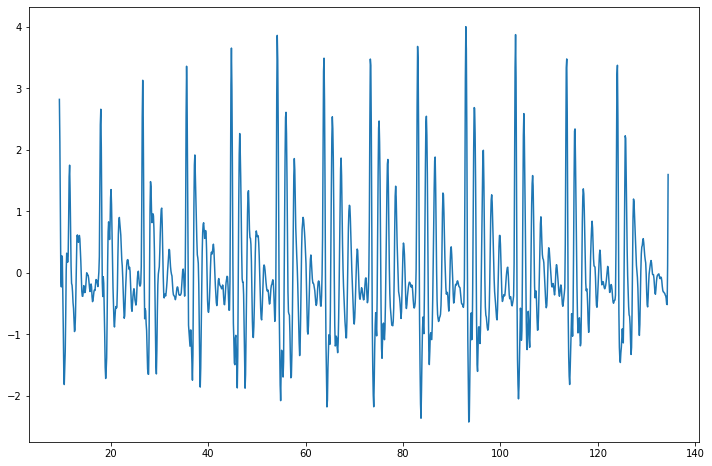

In [25]:
source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.PZ(4, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 15, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

## Try ESS with N(0,I) prior

**NOTE:** no need for logjoint Jacobian corrections! This is because if $x(z) = \text{some transformation of $z$}$ and $$P_Z(z) \propto L(z) p_Z(z)$$, *directly transforming* to the posterior of $x$ $P_X(x)$ from the posterior of $z$ $P_Z(z)$ gives:

$$ P_X(x) = P_Z(z(x)) \Big|{dz \over dx}\Big| \propto L(z(x)) \underbrace{p_Z(z(x)) \Big|{dz \over dx}\Big|}_{=p_X(x)} $$

So in fact we have:

$$ P(z) \propto L(z) p(z) \iff P(x) \propto L(z(x)) p(x) $$

Where in both cases the proportionality constant is equal to $p(D) = \int dz P(z) p(z) = \int dx P(x) dx$.
This is the reason why in NS there is no correction to the loglikelihood function.
Transformation of the posterior samples $x \sim P(x)$ via $z(x)$ takes care of the density corrections automatically.

However, corrections to the log joint density are still necessary for density optimisation like VI and MAP because we need the actual **value** of $p(x) = p(z) \times \Big|{dz \over dx}\Big|$ which we cannot "sample away" by sampling from $p(x)$ (the act of which automatically takes care of the density correction) -- we must supply the density correction $\Big|{dz \over dx}\Big|$ manually because we are not working with a sampling algorithm: the particles in VI just move around, they are not samples.
[*Is this the underlying motivation for natural gradients -- do they haphazerdly sample from the prior in a way?*]
[**This alone strongly suggests that any optimization algorithm should always SAMPLE from the prior.**]

It might be much more efficient to use the full covariance matrix, because ESS might use that structure for better drows. But first we try the whitened one.

In [26]:
import blackjax
import jax.scipy

In [27]:
#hyper = process.hyper_variation(hyper, filter=filter.PZ(5, numpy_backend=jax.numpy, scipy_backend=jax.scipy))

In [28]:
ndim = model.ndim(hyper)
print(ndim)
theta_bijector = model.theta_trajectory_bijector(hyper)

def loglike(w):
    """Return L(theta(w))"""
    theta = theta_bijector.forward(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood

loglike(randn(ndim))

282
[Memory]3255.0s, 54.3min: Loading posterior_of_fitted_lf_values...
[Memory]3255.0s, 54.3min: Loading run_nested...
[Memory]3258.4s, 54.3min: Loading posterior_of_fitted_TFB_values...
[Memory]3258.4s, 54.3min: Loading run_nested...


DeviceArray(-11998.24993509, dtype=float64)

In [29]:
import jax.random as jrnd

def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    @jax.jit
    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

In [ ]:
%%time
n_iter = 1000

init, kernel = blackjax.elliptical_slice(
    loglike, mean=jnp.zeros(ndim), cov=jnp.eye(ndim)
)

w0 = zeros(ndim)

states, info = inference_loop(
    jaxkey(111), init(w0), kernel, n_iter
)

samples = states.position
plot(states.loglikelihood)

0	log L = -306.46445540373475	SNR [dB] = 13.084980330423237
1	log L = -314.5004996012748	SNR [dB] = 13.094184998243609
2	log L = -259.22206510923615	SNR [dB] = 13.62518986521954
3	log L = -268.52464966019124	SNR [dB] = 13.564245388973156
4	log L = -317.12475001828784	SNR [dB] = 12.674713375781561
5	log L = -299.18534599670465	SNR [dB] = 13.337299699056683
6	log L = -299.18534599670465	SNR [dB] = 13.337299699056683
7	log L = -325.29351552113985	SNR [dB] = 12.73806662276883
8	log L = -329.6677538769361	SNR [dB] = 12.82567677921209
9	log L = -251.65302405874365	SNR [dB] = 14.132443790396731


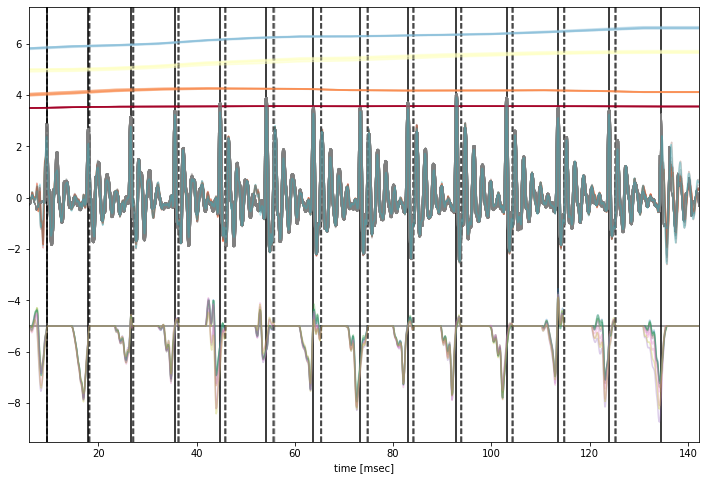

In [31]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 10
warmup = int(n_iter/2)
tail = n_iter - warmup
w_samples = samples[-tail:,:][np.random.randint(tail, size=nsamp),:]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

CPU times: user 13min 40s, sys: 34.4 s, total: 14min 14s
Wall time: 14min 12s


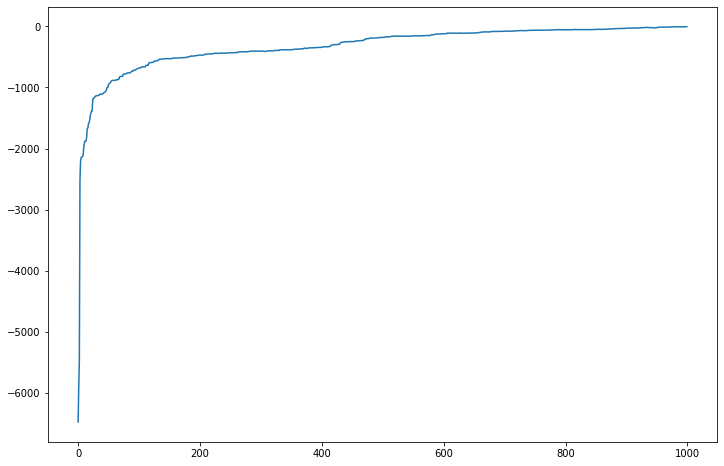

In [34]:
%%time
n_iter = 1000

init, kernel = blackjax.elliptical_slice(
    loglike, mean=jnp.zeros(ndim), cov=jnp.eye(ndim)
)

w0 = randn(ndim)

states, info = inference_loop(
    jaxkey(), init(w0), kernel, n_iter
)

samples = states.position
plot(states.loglikelihood)

0	log L = -69.04892521188481	SNR [dB] = 16.01613427913387
1	log L = -110.05646240183069	SNR [dB] = 15.861196437466972
2	log L = -151.7451053478178	SNR [dB] = 15.115488173366602
3	log L = -111.46813070599023	SNR [dB] = 15.498481342066272
4	log L = -160.6051003914838	SNR [dB] = 14.423543039196714
5	log L = -52.794528300978754	SNR [dB] = 16.29310271227992
6	log L = -90.85485268515708	SNR [dB] = 15.94537960522857
7	log L = -60.697097052545814	SNR [dB] = 15.986156650818122
8	log L = -69.32607173740985	SNR [dB] = 16.02234476627853
9	log L = -106.06213686747037	SNR [dB] = 16.1245606548662


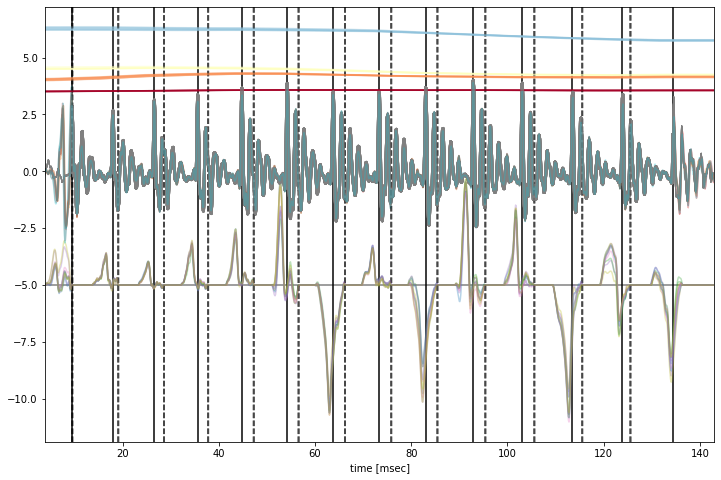

In [35]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 10
warmup = int(n_iter/2)
tail = n_iter - warmup
w_samples = samples[-tail:,:][np.random.randint(tail, size=nsamp),:]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

In [36]:
theta

{'noise_sigma': DeviceArray(0.15623271, dtype=float64),
 'delta': DeviceArray(-0.03121321, dtype=float64),
 'source': DeviceArray([[ 1.69470659,  0.0765282 ,  9.28670597,  0.60137705],
              [ 1.88893191,  0.07960658,  9.54808443,  0.56699556],
              [ 1.92555508,  0.09479922,  9.52120976,  0.55686024],
              [ 2.28423002,  0.11497655,  9.16357653,  0.62989275],
              [ 2.15335532,  0.10813872,  9.46983742,  0.61189225],
              [ 2.05414421,  0.10184569,  9.320697  ,  0.60784716],
              [ 2.43533874,  0.11590387,  9.62883149,  0.645568  ],
              [ 3.02521308,  0.15021943,  9.53261776,  0.63935845],
              [ 3.09493744,  0.15606646,  9.62512527,  0.63179344],
              [ 2.88503131,  0.12468223,  9.97553386,  0.63168423],
              [ 3.01823583,  0.13875636, 10.17158644,  0.61768409],
              [ 3.32648838,  0.15344736,  9.92771264,  0.62957737],
              [ 4.00106343,  0.18689972, 10.02759247,  0.63225227],

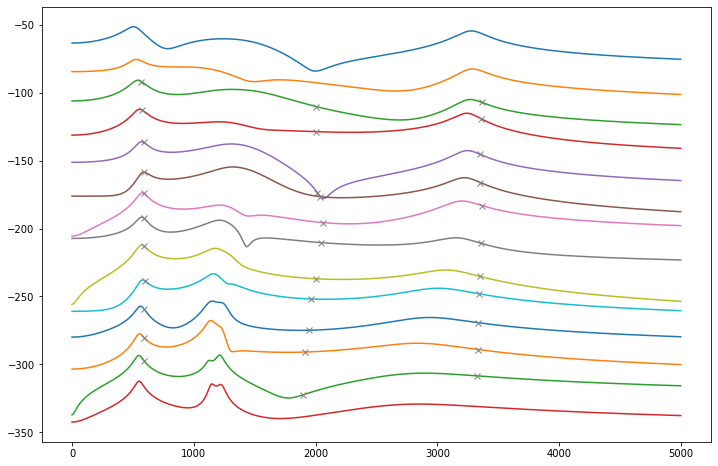

In [37]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

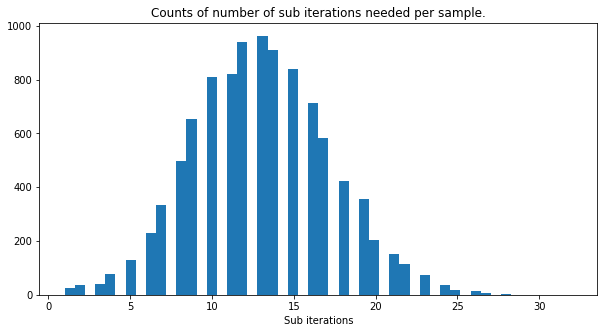

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(np.array(info.subiter), bins=50)
plt.xlabel("Sub iterations")
plt.title("Counts of number of sub iterations needed per sample.")
plt.show()

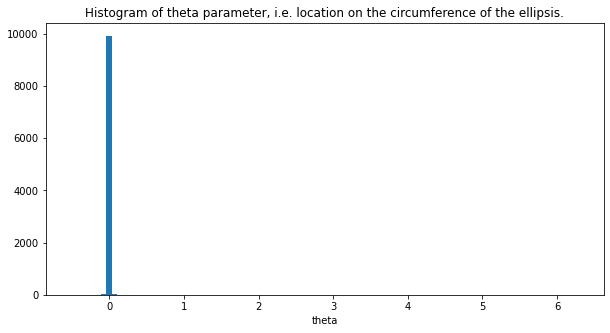

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(np.array(info.theta), bins=100)
plt.xlabel("theta")
plt.title(
    "Histogram of theta parameter, i.e. location on the circumference of the ellipsis."
)
plt.show()